# MA
## Moving Averages
In this section we'll compare <em>Simple Moving Averages</em> to <em>Exponentially Weighted Moving Averages</em> in terms of complexity and performance.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong><a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html'>pandas.DataFrame.rolling</a></strong><font color=black>(window)</font>&nbsp;&nbsp;
Provides rolling window calculations<br>
<strong><a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html'>pandas.DataFrame.ewm</a></strong><font color=black>(span)</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Provides exponential weighted functions</tt></div></div>

### Perform standard imports and load the dataset
For these examples we'll use the International Airline Passengers dataset, which gives monthly totals in thousands from January 1949 to December 1960.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [41]:
airline = pd.read_csv('../Data/airline_passengers.csv',parse_dates=True)

In [43]:
airline.dropna(inplace=True)

In [45]:
airline.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


___
# SMA
## Simple Moving Average

We've already shown how to create a <a href='https://en.wikipedia.org/wiki/Moving_average#Simple_moving_average'>simple moving average</a> by applying a <tt>mean</tt> function to a rolling window.

For a quick review:

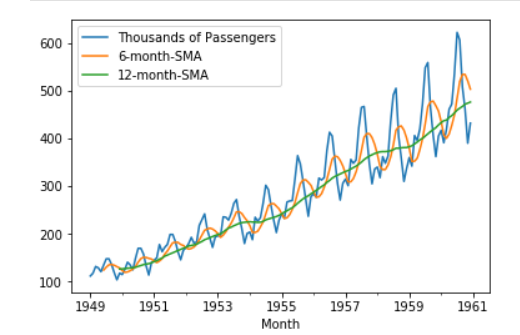

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)


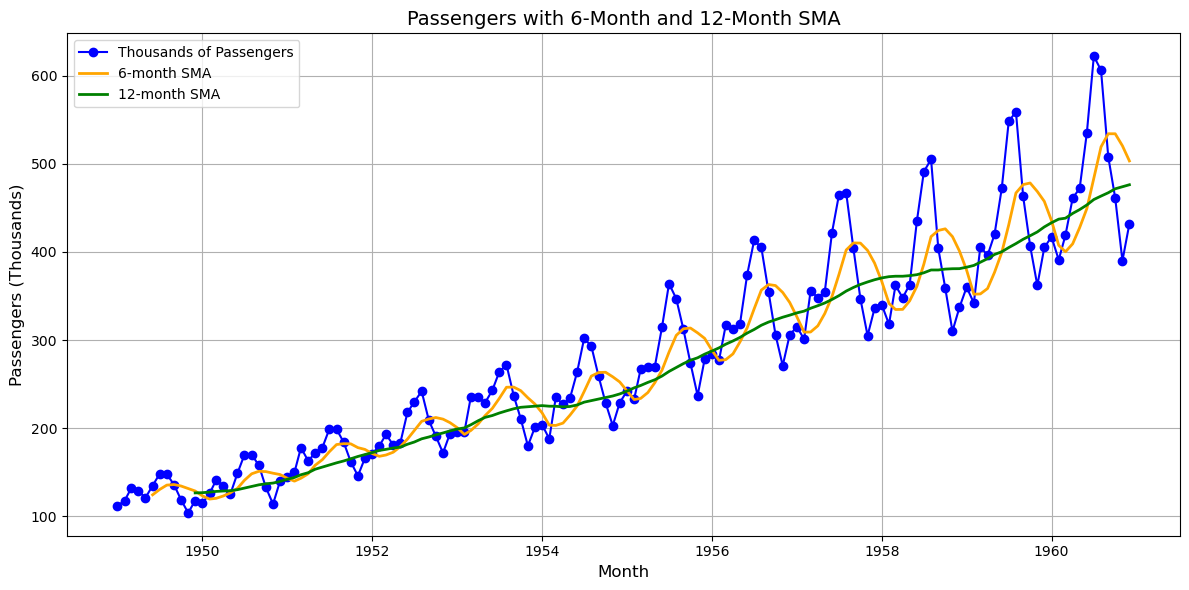

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# 'Month' sütununu datetime formatına çeviriyoruz
airline["Month"] = pd.to_datetime(airline["Month"])

# 'Month' sütununu indeks olarak ayarlıyoruz
airline.set_index("Month", inplace=True)
print(airline.index)  # 'Month' sütunu artık burada yer alıyor

# Hareketli ortalamaları hesaplama
airline["6-month-SMA"] = airline["Thousands of Passengers"].rolling(window=6).mean()
airline["12-month-SMA"] = airline["Thousands of Passengers"].rolling(window=12).mean()

# Grafik çizimi
plt.figure(figsize=(12, 6))
plt.plot(airline.index, airline["Thousands of Passengers"], label="Thousands of Passengers", color="blue", marker="o")
plt.plot(airline.index, airline["6-month-SMA"], label="6-month SMA", color="orange", linewidth=2)
plt.plot(airline.index, airline["12-month-SMA"], label="12-month SMA", color="green", linewidth=2)

# Grafik özellikleri
plt.title("Passengers with 6-Month and 12-Month SMA", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Passengers (Thousands)", fontsize=12)
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


___
# EWMA
## Exponentially Weighted Moving Average 

We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an <a href='https://en.wikipedia.org/wiki/Exponential_smoothing'>EWMA (Exponentially weighted moving average)</a>.

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.



The formula for EWMA is:
### $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

In [54]:
airline['EWMA12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()

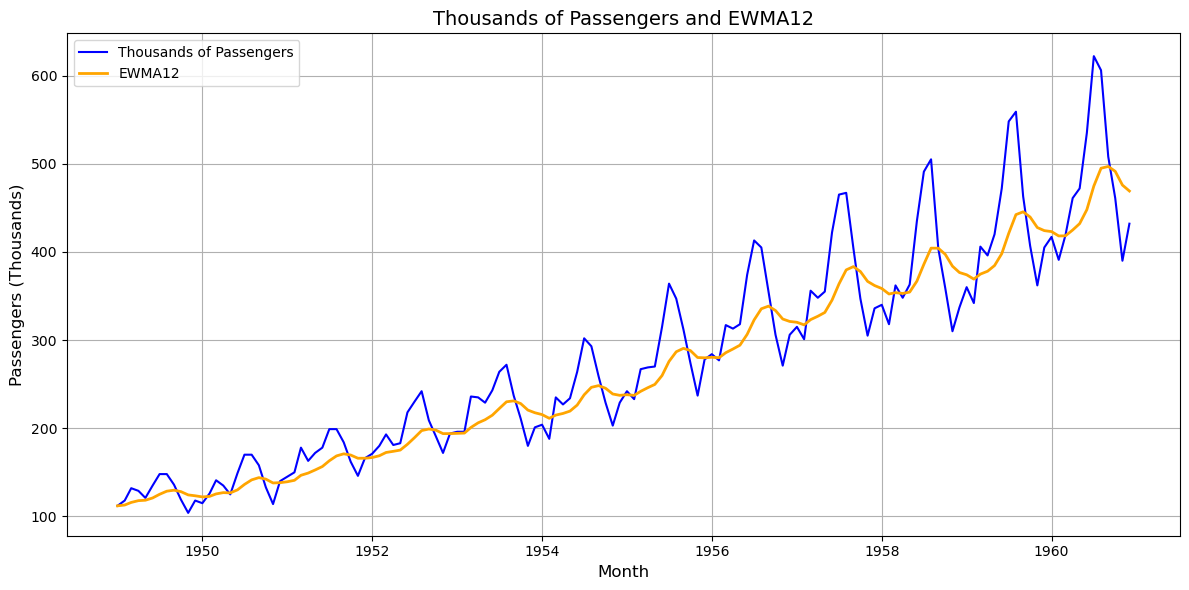

In [60]:
import matplotlib.pyplot as plt

# Grafik çizimi
plt.figure(figsize=(12, 6))
plt.plot(airline.index, airline["Thousands of Passengers"], label="Thousands of Passengers", color="blue")
plt.plot(airline.index, airline["EWMA12"], label="EWMA12", color="orange", linewidth=2)

# Grafik özellikleri
plt.title("Thousands of Passengers and EWMA12", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Passengers (Thousands)", fontsize=12)
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparing SMA to EWMA

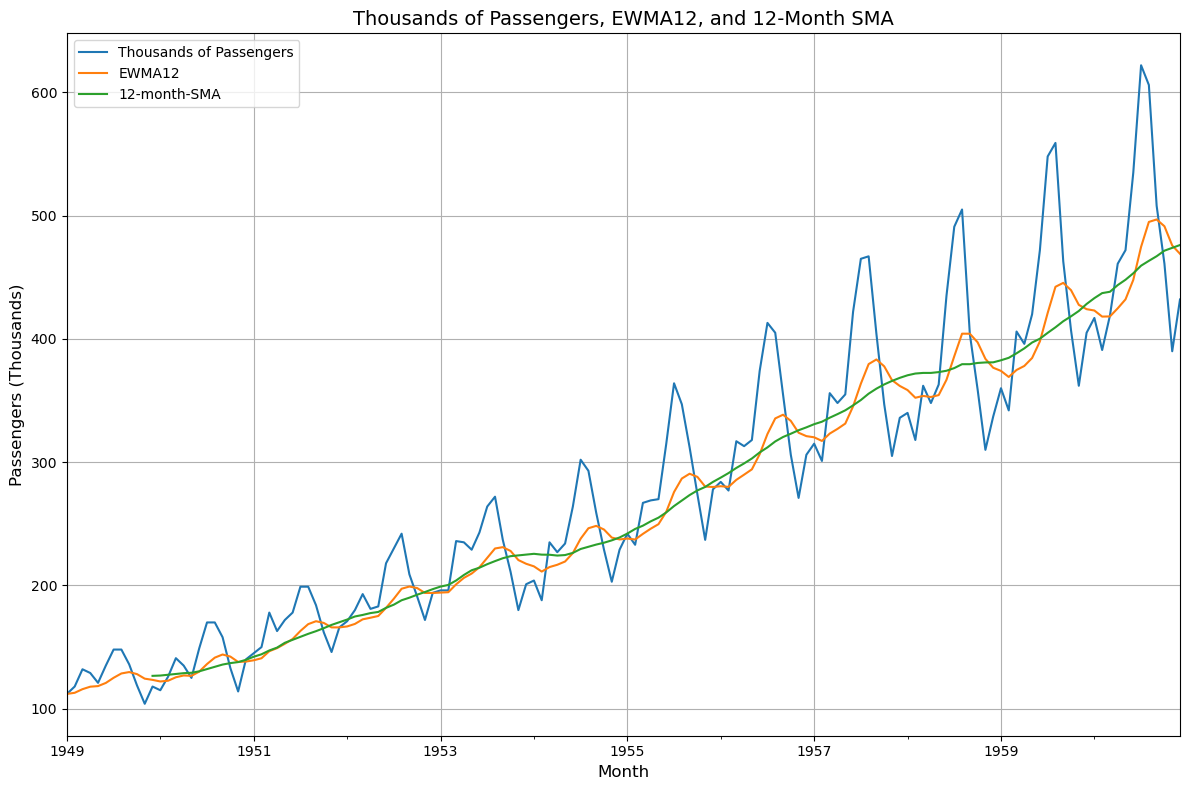

In [62]:
# Grafik çizimi
airline[['Thousands of Passengers', 'EWMA12', '12-month-SMA']].plot(figsize=(12, 8))

# Grafik özelliklerini ayarlama
plt.title("Thousands of Passengers, EWMA12, and 12-Month SMA", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Passengers (Thousands)", fontsize=12)
plt.grid(True)

# X eksenini sıkıştırma
plt.gca().autoscale(axis='x', tight=True)

# Grafik gösterme
plt.tight_layout()
plt.show()


## Simple Exponential Smoothing
The above example employed <em>Simple Exponential Smoothing</em> with one smoothing factor <strong>α</strong>. Unfortunately, this technique does a poor job of forecasting when there is a trend in the data as seen above. In the next section we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the Holt-Winters Methods.